In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


In [4]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [5]:
# Dataset parameters
img_height, img_width = 224, 224
batch_size = 32
num_classes = 4  # Real, Altered-Easy, Altered-Medium, Altered-Hard
num_epochs = 30

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
# Define directories
base_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset"  # Replace with your dataset path
if not os.path.exists(base_dir):
    print(f"Error: Directory '{base_dir}' does not exist")
    exit(1)
else:
    print("Dir read")
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Val')
test_dir = os.path.join(base_dir, 'Test')

Dir read


In [8]:
# Data transformations
# For training - with augmentations specific to fingerprints
train_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(size=(img_height, img_width), scale=(0.9, 1.0)),
    transforms.ColorJitter(brightness=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [9]:
# For validation and testing - just resize and normalize
val_test_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)

In [11]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
# Print class mapping
class_names = train_dataset.classes
print(f"Class mapping: {train_dataset.class_to_idx}")
print(f"Classes: {class_names}")

Class mapping: {'Altered-Easy': 0, 'Altered-Hard': 1, 'Altered-Medium': 2, 'Real': 3}
Classes: ['Altered-Easy', 'Altered-Hard', 'Altered-Medium', 'Real']


In [13]:

# Load pre-trained EfficientNet model
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 86.0MB/s]


In [14]:
# Freeze base model parameters
for param in model.features.parameters():
    param.requires_grad = False

In [15]:
# Modify the classifier
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(num_ftrs, num_classes)
)


In [16]:
# Move model to device
model = model.to(device)


In [17]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_val_acc = 0.0
    best_model_wts = None

    # History for plotting
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=f"{phase}"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            # Update history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.cpu().item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.cpu().item())
                # Update LR scheduler
                scheduler.step(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save best model
            if phase == 'val' and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
                torch.save(model.state_dict(), 'best_fingerprint_efficientnet.pth')
                print("Saved new best model")

        print()

    # After all epochs, load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [19]:
# Phase 1: Train only the classifier
print("Phase 1: Training classifier only")
model_phase1, history_phase1 = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

Phase 1: Training classifier only
Epoch 1/10
----------


train: 100%|██████████| 525/525 [22:48<00:00,  2.61s/it]


train Loss: 1.0398 Acc: 0.5341


val: 100%|██████████| 75/75 [03:42<00:00,  2.97s/it]


val Loss: 0.9084 Acc: 0.6058
Saved new best model

Epoch 2/10
----------


train: 100%|██████████| 525/525 [01:39<00:00,  5.27it/s]


train Loss: 0.9221 Acc: 0.5880


val: 100%|██████████| 75/75 [00:09<00:00,  7.55it/s]


val Loss: 0.8433 Acc: 0.6254
Saved new best model

Epoch 3/10
----------


train: 100%|██████████| 525/525 [01:39<00:00,  5.25it/s]


train Loss: 0.9056 Acc: 0.5944


val: 100%|██████████| 75/75 [00:10<00:00,  6.99it/s]


val Loss: 0.8702 Acc: 0.6092

Epoch 4/10
----------


train: 100%|██████████| 525/525 [01:39<00:00,  5.25it/s]


train Loss: 0.8904 Acc: 0.6018


val: 100%|██████████| 75/75 [00:10<00:00,  7.44it/s]


val Loss: 0.8389 Acc: 0.6225

Epoch 5/10
----------


train: 100%|██████████| 525/525 [01:40<00:00,  5.24it/s]


train Loss: 0.8810 Acc: 0.6082


val: 100%|██████████| 75/75 [00:10<00:00,  7.15it/s]


val Loss: 0.8276 Acc: 0.6238

Epoch 6/10
----------


train: 100%|██████████| 525/525 [01:42<00:00,  5.13it/s]


train Loss: 0.8845 Acc: 0.6046


val: 100%|██████████| 75/75 [00:09<00:00,  8.06it/s]


val Loss: 0.8162 Acc: 0.6354
Saved new best model

Epoch 7/10
----------


train: 100%|██████████| 525/525 [01:40<00:00,  5.22it/s]


train Loss: 0.8766 Acc: 0.6063


val: 100%|██████████| 75/75 [00:09<00:00,  7.68it/s]


val Loss: 0.8438 Acc: 0.6192

Epoch 8/10
----------


train: 100%|██████████| 525/525 [01:39<00:00,  5.27it/s]


train Loss: 0.8784 Acc: 0.6072


val: 100%|██████████| 75/75 [00:10<00:00,  7.24it/s]


val Loss: 0.8214 Acc: 0.6333

Epoch 9/10
----------


train: 100%|██████████| 525/525 [01:39<00:00,  5.26it/s]


train Loss: 0.8757 Acc: 0.6086


val: 100%|██████████| 75/75 [00:10<00:00,  7.00it/s]


val Loss: 0.8184 Acc: 0.6338

Epoch 10/10
----------


train: 100%|██████████| 525/525 [01:43<00:00,  5.07it/s]


train Loss: 0.8653 Acc: 0.6094


val: 100%|██████████| 75/75 [00:09<00:00,  8.15it/s]

val Loss: 0.8486 Acc: 0.6275



In [20]:
# Phase 2: Fine-tune the last few layers of EfficientNet
print("Phase 2: Fine-tuning last layers of EfficientNet")

Phase 2: Fine-tuning last layers of EfficientNet


In [21]:
# Unfreeze the last few layers
for i, param in enumerate(model.features.parameters()):
    if i > len(list(model.features.parameters())) - 20:  # Unfreeze last 20 layers
        param.requires_grad = True

In [22]:
# Lower learning rate for fine-tuning
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

In [23]:
# Continue training
model_phase2, history_phase2 = train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------


train: 100%|██████████| 525/525 [01:43<00:00,  5.05it/s]


train Loss: 0.7280 Acc: 0.6729


val: 100%|██████████| 75/75 [00:10<00:00,  7.03it/s]


val Loss: 0.5736 Acc: 0.7375
Saved new best model

Epoch 2/20
----------


train: 100%|██████████| 525/525 [01:43<00:00,  5.09it/s]


train Loss: 0.5891 Acc: 0.7314


val: 100%|██████████| 75/75 [00:10<00:00,  6.86it/s]


val Loss: 0.4971 Acc: 0.7596
Saved new best model

Epoch 3/20
----------


train: 100%|██████████| 525/525 [01:43<00:00,  5.08it/s]


train Loss: 0.5291 Acc: 0.7601


val: 100%|██████████| 75/75 [00:10<00:00,  6.94it/s]


val Loss: 0.4724 Acc: 0.7842
Saved new best model

Epoch 4/20
----------


train: 100%|██████████| 525/525 [01:38<00:00,  5.31it/s]


train Loss: 0.4979 Acc: 0.7762


val: 100%|██████████| 75/75 [00:10<00:00,  7.18it/s]


val Loss: 0.4270 Acc: 0.8046
Saved new best model

Epoch 5/20
----------


train: 100%|██████████| 525/525 [01:39<00:00,  5.29it/s]


train Loss: 0.4727 Acc: 0.7861


val: 100%|██████████| 75/75 [00:10<00:00,  7.12it/s]


val Loss: 0.4257 Acc: 0.8008

Epoch 6/20
----------


train: 100%|██████████| 525/525 [01:42<00:00,  5.14it/s]


train Loss: 0.4468 Acc: 0.7989


val: 100%|██████████| 75/75 [00:10<00:00,  6.88it/s]


val Loss: 0.3991 Acc: 0.8108
Saved new best model

Epoch 7/20
----------


train: 100%|██████████| 525/525 [01:38<00:00,  5.31it/s]


train Loss: 0.4274 Acc: 0.8071


val: 100%|██████████| 75/75 [00:10<00:00,  7.06it/s]


val Loss: 0.3910 Acc: 0.8113
Saved new best model

Epoch 8/20
----------


train: 100%|██████████| 525/525 [01:42<00:00,  5.13it/s]


train Loss: 0.4046 Acc: 0.8170


val: 100%|██████████| 75/75 [00:10<00:00,  6.83it/s]


val Loss: 0.3897 Acc: 0.8113

Epoch 9/20
----------


train: 100%|██████████| 525/525 [01:41<00:00,  5.18it/s]


train Loss: 0.4018 Acc: 0.8147


val: 100%|██████████| 75/75 [00:11<00:00,  6.66it/s]


val Loss: 0.3726 Acc: 0.8196
Saved new best model

Epoch 10/20
----------


train: 100%|██████████| 525/525 [01:41<00:00,  5.15it/s]


train Loss: 0.3885 Acc: 0.8182


val: 100%|██████████| 75/75 [00:11<00:00,  6.74it/s]


val Loss: 0.3744 Acc: 0.8171

Epoch 11/20
----------


train: 100%|██████████| 525/525 [01:43<00:00,  5.06it/s]


train Loss: 0.3806 Acc: 0.8215


val: 100%|██████████| 75/75 [00:10<00:00,  7.00it/s]


val Loss: 0.3604 Acc: 0.8254
Saved new best model

Epoch 12/20
----------


train: 100%|██████████| 525/525 [01:41<00:00,  5.17it/s]


train Loss: 0.3705 Acc: 0.8283


val: 100%|██████████| 75/75 [00:09<00:00,  7.73it/s]


val Loss: 0.3585 Acc: 0.8263
Saved new best model

Epoch 13/20
----------


train: 100%|██████████| 525/525 [01:45<00:00,  4.98it/s]


train Loss: 0.3668 Acc: 0.8317


val: 100%|██████████| 75/75 [00:09<00:00,  7.96it/s]


val Loss: 0.3698 Acc: 0.8225

Epoch 14/20
----------


train: 100%|██████████| 525/525 [01:42<00:00,  5.11it/s]


train Loss: 0.3543 Acc: 0.8399


val: 100%|██████████| 75/75 [00:09<00:00,  7.71it/s]


val Loss: 0.3628 Acc: 0.8242

Epoch 15/20
----------


train: 100%|██████████| 525/525 [01:44<00:00,  5.03it/s]


train Loss: 0.3394 Acc: 0.8412


val: 100%|██████████| 75/75 [00:10<00:00,  7.12it/s]


val Loss: 0.3489 Acc: 0.8325
Saved new best model

Epoch 16/20
----------


train: 100%|██████████| 525/525 [01:42<00:00,  5.13it/s]


train Loss: 0.3453 Acc: 0.8408


val: 100%|██████████| 75/75 [00:11<00:00,  6.77it/s]


val Loss: 0.3623 Acc: 0.8258

Epoch 17/20
----------


train: 100%|██████████| 525/525 [01:40<00:00,  5.22it/s]


train Loss: 0.3355 Acc: 0.8459


val: 100%|██████████| 75/75 [00:11<00:00,  6.70it/s]


val Loss: 0.3554 Acc: 0.8321

Epoch 18/20
----------


train: 100%|██████████| 525/525 [01:43<00:00,  5.06it/s]


train Loss: 0.3291 Acc: 0.8476


val: 100%|██████████| 75/75 [00:10<00:00,  6.91it/s]


val Loss: 0.3455 Acc: 0.8329
Saved new best model

Epoch 19/20
----------


train: 100%|██████████| 525/525 [01:42<00:00,  5.11it/s]


train Loss: 0.3178 Acc: 0.8537


val: 100%|██████████| 75/75 [00:11<00:00,  6.79it/s]


val Loss: 0.3499 Acc: 0.8288

Epoch 20/20
----------


train: 100%|██████████| 525/525 [01:45<00:00,  4.98it/s]


train Loss: 0.3182 Acc: 0.8505


val: 100%|██████████| 75/75 [00:09<00:00,  7.57it/s]

val Loss: 0.3428 Acc: 0.8358
Saved new best model



In [24]:
# Save final model
torch.save(model.state_dict(), 'final_fingerprint_efficientnet.pth')
print("Final model saved!")

Final model saved!


In [25]:
# Evaluate on test set
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct.double() / len(test_loader.dataset)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return all_preds, all_labels, cm

In [26]:
# Evaluate the final model
y_pred, y_true, cm = evaluate_model(model, test_loader)

Testing: 100%|██████████| 150/150 [07:29<00:00,  3.00s/it]

Test Loss: 0.3830
Test Accuracy: 0.8231

Classification Report:
                precision    recall  f1-score   support

  Altered-Easy       0.94      0.89      0.91      1200
  Altered-Hard       0.73      0.71      0.72      1200
Altered-Medium       0.71      0.70      0.70      1200
          Real       0.91      0.99      0.95      1200

      accuracy                           0.82      4800
     macro avg       0.82      0.82      0.82      4800
  weighted avg       0.82      0.82      0.82      4800



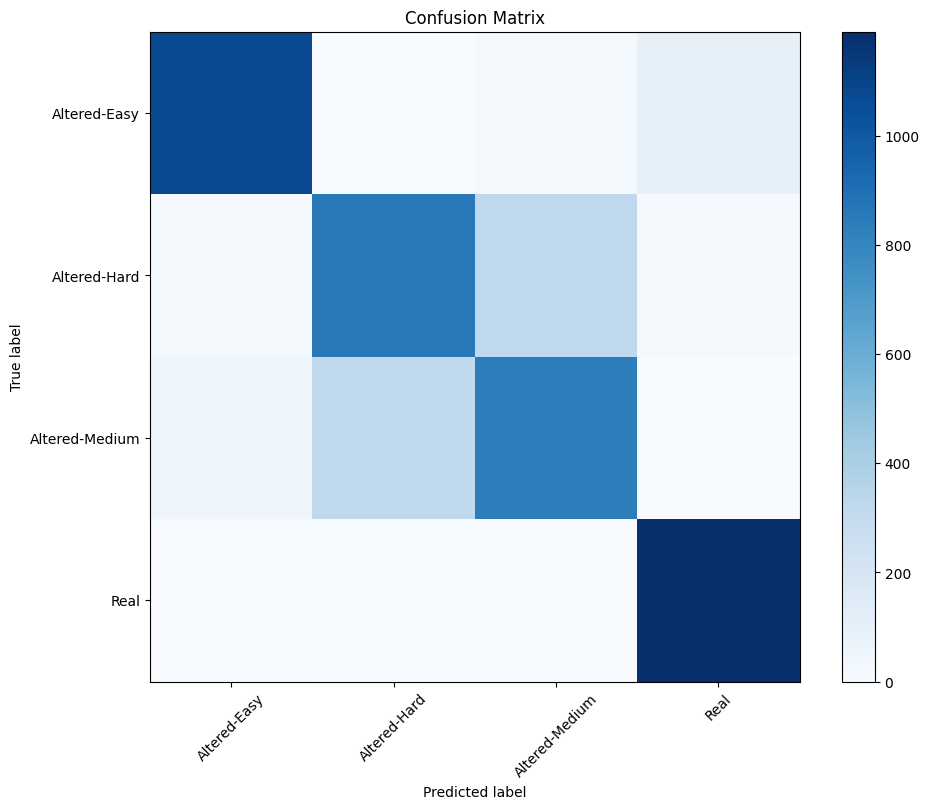

In [27]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png')


In [28]:
# Function to plot training history
def plot_training_history(history_phase1, history_phase2=None):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_phase1['train_acc'], label='Phase 1 Train')
    plt.plot(history_phase1['val_acc'], label='Phase 1 Validation')

    if history_phase2 is not None:
        start_epoch = len(history_phase1['train_acc'])
        epochs_range = range(start_epoch, start_epoch + len(history_phase2['train_acc']))
        plt.plot(epochs_range, history_phase2['train_acc'], label='Phase 2 Train')
        plt.plot(epochs_range, history_phase2['val_acc'], label='Phase 2 Validation')

    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history_phase1['train_loss'], label='Phase 1 Train')
    plt.plot(history_phase1['val_loss'], label='Phase 1 Validation')

    if history_phase2 is not None:
        plt.plot(epochs_range, history_phase2['train_loss'], label='Phase 2 Train')
        plt.plot(epochs_range, history_phase2['val_loss'], label='Phase 2 Validation')

    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

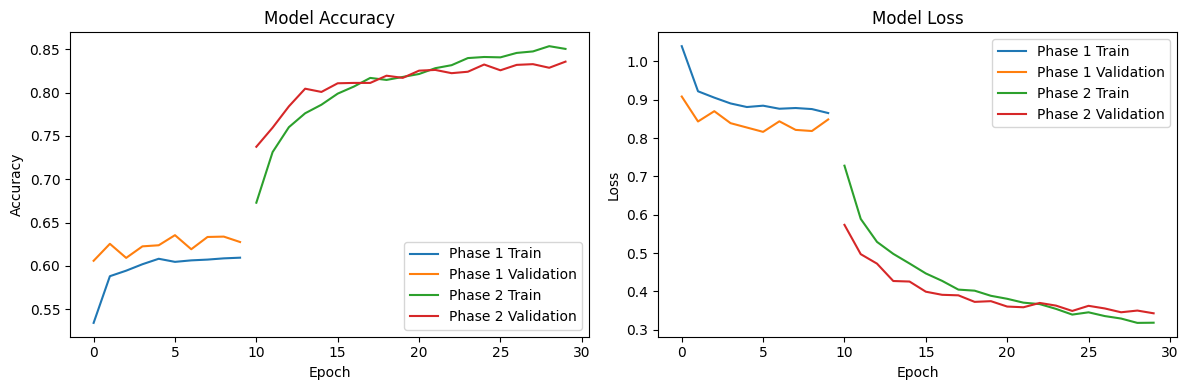

In [29]:
# Plot training history
history_phase1_dict = {
    'train_loss': history_phase1['train_loss'],
    'val_loss': history_phase1['val_loss'],
    'train_acc': history_phase1['train_acc'],
    'val_acc': history_phase1['val_acc']
}

history_phase2_dict = {
    'train_loss': history_phase2['train_loss'],
    'val_loss': history_phase2['val_loss'],
    'train_acc': history_phase2['train_acc'],
    'val_acc': history_phase2['val_acc']
}

plot_training_history(history_phase1_dict, history_phase2_dict)